Set True to save the figures.

In [1]:
save = True

## Reused Code from Question 5

In [2]:
import cv2
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
from skimage.color import rgb2gray # converting rgb images to grayscale

def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

def non_max_suppression(gradient_magnitudes, gradient_directions):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """
    #INSERT YOUR CODE HERE
    height, width = gradient_magnitudes.shape
    output = np.zeros_like(gradient_magnitudes, dtype=np.uint8)
    gradient_directions *= (180 / np.pi)

    for i in range(1, height-1):
        for j in range(1, width-1):
            mag = gradient_magnitudes[i, j]
            angle = gradient_directions[i,j]

            if (0<=angle<22.5) or (157.5 <= angle <= 180) or (-22.5 <= angle < 0) or (-180 <= angle < -157.5):
                prev_pixel = gradient_magnitudes[i, j-1]
                next_pixel = gradient_magnitudes[i, j+1]
            elif (112.5 <= angle < 157.5) or (-67.5 <= angle < -22.5):
                prev_pixel = gradient_magnitudes[i-1, j-1]
                next_pixel = gradient_magnitudes[i+1, j+1]
            elif (67.5 <= angle < 112.5) or (-112.5 <= angle < -67.5):
                prev_pixel = gradient_magnitudes[i-1, j]
                next_pixel = gradient_magnitudes[i+1, j]
            elif (22.5 <= angle < 67.5) or (-157.5 <= angle < -112.5):
                prev_pixel = gradient_magnitudes[i-1, j+1]
                next_pixel = gradient_magnitudes[i+1, j-1]

            if mag >= prev_pixel and mag >= next_pixel:
                output[i, j] = mag
    
    return output

## Stick Filters

In [3]:
def get_gradient_magnitudes(img, sigma, k=2):
    """
    Get gradient magnitudes of an image
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter            
        k: Parameter to adjust the shape of the (2k + 1, 2k + 1) gaussian blur 
    """
    G = gaussian_blur(sigma, k)
    blurred_img = cross_correlate2D(img, G)
    _, _, gradient_magnitudes, _ = sobel(blurred_img)
    return gradient_magnitudes

Create the kernels of the sticks filters

In [4]:
def get_kernels(): 
    kernel1 = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1/5, 1/5, 1/5, 1/5, 1/5], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
    kernel2 = [[0, 0, 0, 0, 0], [0, 0, 0, 1/5, 1/5], [0, 0, 1/5, 0, 0], [1/5, 1/5, 0, 0, 0], [0, 0, 0, 0, 0]]
    kernel3 = [[0, 0, 0, 0, 1/5], [0, 0, 0, 1/5, 0], [0, 0, 1/5, 0, 0], [0, 1/5, 0, 0, 0], [1/5, 0, 0, 0, 0]]
    kernel4 = [[0, 0, 0, 1/5, 0], [0, 0, 0, 1/5, 0], [0, 0, 1/5, 0, 0], [0, 1/5, 0, 0, 0], [0, 1/5, 0, 0, 0]]
    kernel5 = [[0, 0, 1/5, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 1/5, 0, 0]]
    kernel6 = [[0, 1/5, 0, 0, 0], [0, 1/5, 0, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 0, 1/5, 0], [0, 0, 0, 1/5, 0]]
    kernel7 = [[1/5, 0, 0, 0, 0], [0, 1/5, 0, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 0, 1/5, 0], [0, 0, 0, 0, 1/5]]
    kernel8 = [[0, 0, 0, 0, 0], [1/5, 1/5, 0, 0, 0], [0, 0, 1/5, 0, 0], [0, 0, 0, 1/5, 1/5], [0, 0, 0, 0, 0]]
    return [kernel1, kernel2, kernel3, kernel4, kernel5, kernel6, kernel7, kernel8]

Stick Filter

In [5]:
def stick_filters(img, sigma, n): 
    """
    Applys Stick Filter Algorithm to a given image.
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter            
        n: length of each stick
    """
    magnitudes = get_gradient_magnitudes(img, sigma)
    magnitudes = magnitudes.astype(np.float32)
    kernel = np.ones((n, n), np.float32) / (n**2)
    
    avg_intensity = cv2.filter2D(magnitudes, -1, kernel) 

    kernels = get_kernels()
    intensities = []
    for k in kernels: 
        intensities.append(cv2.filter2D(magnitudes, -1, np.asarray(k)))
    
    row, col = magnitudes.shape 
    for i in range(row): 
        for j in range(col): 
            max_diff = []
            avg_neighbor = avg_intensity[i, j]
            for stick in intensities: 
                avg_stick = stick[i, j]
                max_diff.append(np.abs(avg_neighbor - avg_stick))
            magnitudes[i, j] = max(max_diff)

    return magnitudes

## Results

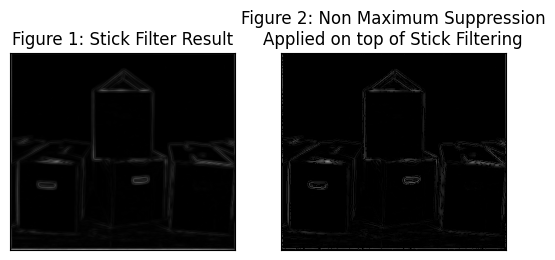

In [6]:
img = cv2.imread('edge4.jpg', cv2.IMREAD_GRAYSCALE)
_, _, _, gradient_directions = sobel(img)

n = 5
stick_res_magnitudes = stick_filters(img, 1, 5)
nms_img = non_max_suppression(stick_res_magnitudes, gradient_directions)

plt.subplot(121),plt.imshow(stick_res_magnitudes,cmap = 'gray')
plt.title('Figure 1: Stick Filter Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(nms_img,cmap = 'gray')
plt.title('Figure 2: Non Maximum Suppression\nApplied on top of Stick Filtering'), plt.xticks([]), plt.yticks([])
if save:
    plt.savefig('Stick_results.png')
plt.show()

Above are my results from applying the stick filtering on image 'edge4.jpg'. Figure 1 is the result of applying stick filters to the original image. Figure 2 is the result of applying non-maximum suppression to the result of Fig. 1.